In [6]:
from typing import Dict
from collections import defaultdict

def plot_map_vs_mar_at_steps(
    log_files,
    map_key="coco/bbox_mAP",
    mar_key="coco/bbox_AR@100",
    target_steps=(12, 24, 36),
    step_key_preference="epoch",
    log_labels=None,
    show=True,
    save_path=None,
    dpi=120,
):
    """
    Scatter‑plots mAP (x‑axis) against mAR (y‑axis) for a set of log files.
    Each file contributes one point per *target_step* (e.g. 12, 24, 36).

    Parameters
    ----------
    log_files : sequence of str or Path
        JSON‑lines training/validation logs (one record per line).
    map_key, mar_key : str
        Keys to look up in each JSON line for mAP and mAR.
    target_steps : iterable of int
        Which steps/epochs to sample from each log.
    step_key_preference : {"epoch", "step"}
        When both keys exist, which one to treat as the canonical step index.
    show : bool
        If True, call plt.show().
    save_path : str or Path or None
        If given, saves the figure here (any suffix matplotlib supports).
    dpi : int
        DPI for the saved/ shown figure.
    log_labels : list/tuple OR dict OR None
        • If a sequence → must be same length as `log_files`; positional mapping.  
        • If a dict     → keys are full paths or `Path(...).name`, values are labels.  
        • If None       → falls back to Path(file).name.
    """

    from pathlib import Path
    import json, matplotlib.pyplot as plt, numpy as np

    # ---------- helper to resolve a label for a file -------------------------
    def _label_for(idx, f):
        if log_labels is None:
            return Path(f).name
        if isinstance(log_labels, (list, tuple)):
            return log_labels[idx]
        # dict-like
        return log_labels.get(f, log_labels.get(Path(f).name, Path(f).name))

    # ---------- collect points -----------------------------------------------
    target_steps = set(target_steps)
    points = []
    for file_idx, file_path in enumerate(log_files):
        file_path = Path(file_path)
        found: Dict[int, Dict[str, float]] = {s: {} for s in target_steps}

        try:
            with file_path.open() as fh:
                for line in fh:
                    try:
                        rec = json.loads(line)
                    except json.JSONDecodeError:
                        continue

                    step_val = (
                        rec.get(step_key_preference)
                        or rec.get("epoch")
                        or rec.get("step")
                    )
                    if step_val not in target_steps:
                        continue

                    if map_key in rec:
                        found[step_val][map_key] = rec[map_key]
                    if mar_key in rec:
                        found[step_val][mar_key] = rec[mar_key]

        except FileNotFoundError:
            print(f"[WARN] file not found: {file_path}")
            continue

        for s in sorted(found):
            if map_key in found[s] and mar_key in found[s]:
                points.append(
                    {
                        "map": found[s][map_key],
                        "mar": found[s][mar_key],
                        "step": s,
                        "file_idx": file_idx,
                        "label": file_path.name,
                    }
                )
            else:
                print(
                    f"[WARN] missing {map_key}/{mar_key} at step {s} "
                    f"in {file_path.name}"
                )

    if not points:
        print("[INFO] nothing to plot."); return

    # ---------- plotting -----------------------------------------------------
    fig, ax = plt.subplots(figsize=(8, 7), dpi=dpi)
    n_files = len(log_files)
    cmap = plt.cm.get_cmap("viridis", max(n_files, 1))
    unique_steps = sorted(target_steps)
    markers = ["o", "s", "^", "D", "P", "X", "*", "v"]
    marker_for_step = {s: markers[i % len(markers)] for i, s in enumerate(unique_steps)}

    by_file = defaultdict(list)
    for p in points:
        ax.scatter(
            p["map"], p["mar"],
            marker=marker_for_step[p["step"]],
            s=80,
            color=cmap(p["file_idx"] / max(n_files - 1, 1)),
            edgecolors="k", linewidth=0.4, alpha=0.8,
        )
        by_file[p["file_idx"]].append(p)
    
    # draw faint line (and keep the existing scatter/legends that follow)
    for file_idx, pts in by_file.items():
        pts = sorted(pts, key=lambda d: d["step"])       # order 12‑24‑36
        xs  = [p["map"] for p in pts]
        ys  = [p["mar"] for p in pts]

        ax.plot(
            xs,
            ys,
            linestyle="-",
            linewidth=1.0,
            alpha=0.3,          #  ←  faint line
            color=cmap(file_idx / max(n_files - 1, 1)),
            zorder=1,           # behind the markers
        )

    # -----------------------------------------------------------------------
    # ░░ Draw iso‑F1 (or Fβ) lines behind everything ░░
    # -----------------------------------------------------------------------
    f_levels = [0.3, 0.4, 0.5, 0.6, 0.7]        # tweak as you like
    xmin, xmax = ax.get_xlim()
    x_vals = np.linspace(xmin, xmax, 400)

    for F in f_levels:
        # domain starts at P = F/2
        p = x_vals[x_vals > F / 2 + 1e-6]
        r = (F * p) / (2 * p - F)

        # keep points that land inside current y‑axis limits
        ymask = (r >= ax.get_ylim()[0]) & (r <= ax.get_ylim()[1])
        ax.plot(
            p[ymask],
            r[ymask],
            linestyle="--",
            linewidth=0.8,
            color="grey",
            alpha=0.4,
            zorder=0,           # far behind markers/lines
        )
        # label the curve on the right edge
        if ymask.any():
            ax.text(
                p[ymask][-1],
                r[ymask][-1],
                f"F1={F:.1f}",
                fontsize=8,
                color="grey",
                ha="left",
                va="center",
                alpha=0.6,
            )

    # -------- legend by file (colours) -----------------------------------------
    file_handles = [
        plt.Line2D([0], [0], marker="o", linestyle="", markersize=8,
                markerfacecolor=cmap(i / max(n_files - 1, 1)),
                markeredgecolor="k")
        for i in range(n_files)
    ]
    file_labels = [_label_for(i, f) for i, f in enumerate(log_files)]

    file_legend = ax.legend(  # keep a reference!
        file_handles,
        file_labels,
        title="log file",
        loc="upper left",
        fontsize="small",
    )
    ax.add_artist(file_legend)   # ← tells matplotlib to draw *and keep* this legend


    # -------- legend by step (markers) -----------------------------------------
    step_handles = [
        plt.Line2D([0], [0], marker=marker_for_step[s], linestyle="",
                markersize=8, color="w", markeredgecolor="k")
        for s in unique_steps
    ]
    step_labels = [f"step {s}" for s in unique_steps]

    ax.legend(
        step_handles,
        step_labels,
        title="epoch step",
        loc="lower right",
        fontsize="small",
    )
    ax.set_xlabel(map_key.replace("coco/", "").replace("bbox_", ""))
    ax.set_ylabel(mar_key.replace("coco/", "").replace("bbox_", ""))
    ax.set_title(f"mAP vs mAR at steps {', '.join(map(str, unique_steps))}")
    ax.grid(True, linestyle="--", alpha=0.6)
    fig.tight_layout()

    if save_path: 
        fig.savefig(save_path, dpi=dpi)
    if show: 
        plt.show()
    else:
        plt.close(fig)


[WARN] missing coco/bbox_mAP/coco/bbox_AR@100 at step 36 in scalars.json


/tmp/ipykernel_3631/3774656400.py:108: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis", max(n_files, 1))


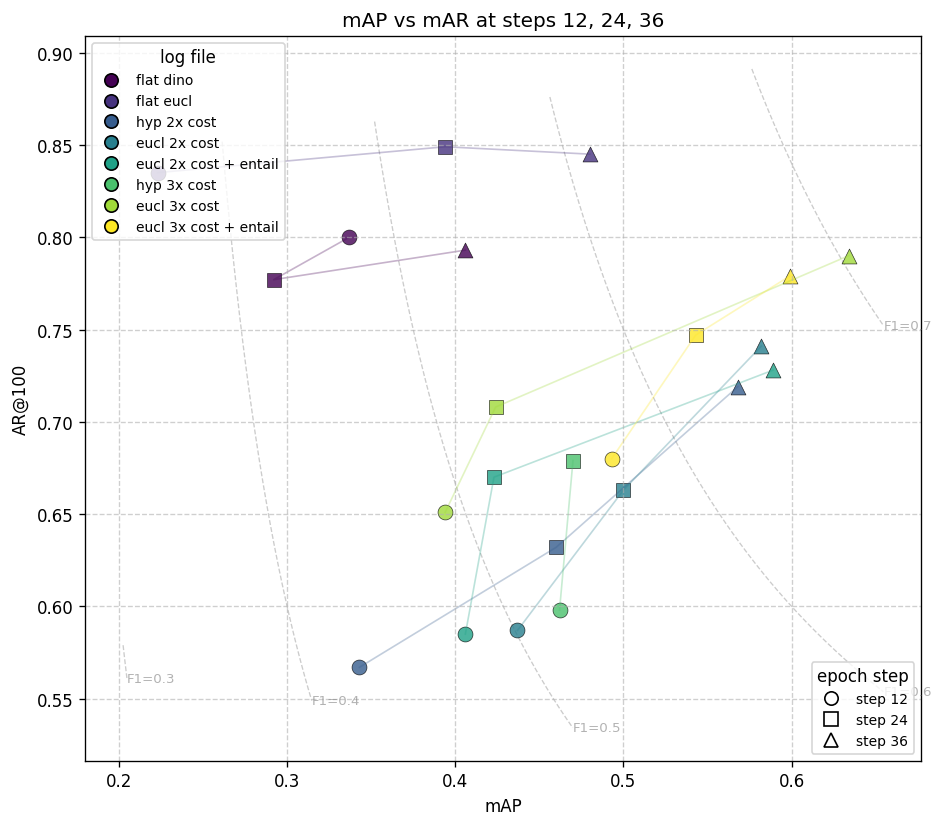

In [11]:
log_file_paths = [
    "work_dirs/dino-4scale_r50-linear_improved_8xb2/20250428_044942/vis_data/scalars.json",
    "work_dirs/dino-4scale_r50-shared-proj_improved_8xb2/20250427_071406/vis_data/scalars.json",
    "work_dirs/dino-4scale_r50_improved_8xb2_hier-aircraft-hyp-2x-cost/20250513_195813/vis_data/scalars.json",
    "work_dirs/dino-4scale_r50_improved_8xb2_hier-aircraft-2x-cost/20250508_162122/vis_data/scalars.json",
    "work_dirs/dino-4scale_r50_improved_8xb2_hier-aircraft-2x-cost-entail/20250510_095737/vis_data/scalars.json",
    "work_dirs/dino-4scale_r50_improved_8xb2_hier-aircraft/20250514_140310/vis_data/scalars.json",
    "work_dirs/dino-4scale_r50_improved_8xb2_hier-aircraft-3x-cost/20250512_012240/vis_data/scalars.json",
    "work_dirs/dino-4scale_r50_improved_8xb2_hier-aircraft-3x-cost-entail-full/20250511_071356/vis_data/scalars.json"
]

custom_labels = [
    "flat dino",
    "flat eucl",
    "hyp 2x cost",
    "eucl 2x cost",
    "eucl 2x cost + entail",
    "hyp 3x cost",
    "eucl 3x cost",
    "eucl 3x cost + entail",
]
plot_map_vs_mar_at_steps(
    log_file_paths,
    map_key="coco/bbox_mAP",
    mar_key="coco/bbox_AR@100",
    target_steps=[12, 24, 36],
    log_labels=custom_labels,
)
